# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Lecture

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [13]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [14]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [15]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


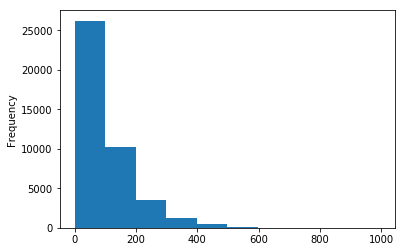

In [16]:
df['pm2.5'].plot.hist();

In [17]:
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
numeric_df = df._get_numeric_data().dropna()
X = numeric_df.drop('pm2.5', axis='columns')
y = numeric_df['pm2.5']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2590006399659215

In [19]:
# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# Also, these formulas break with . in variable name, so lets change that
df = numeric_df.rename(index=str, columns={'pm2.5': 'pm25'})

# Now let's construct the formula string using all columns
quant_formula = 'pm25 ~ ' + ' + '.join(df.drop('pm25', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
quant_reg.summary()  # "summary" is another very R-thing

pm25 ~ No + year + month + day + hour + DEWP + TEMP + PRES + Iws + Is + Ir


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.1600
Model:                       QuantReg   Bandwidth:                       8.276
Method:                 Least Squares   Sparsity:                        133.8
Date:                Fri, 01 Mar 2019   No. Observations:                41757
Time:                        09:15:30   Df Residuals:                    41745
                                        Df Model:                           11
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004   1.67e-05     22.881      0.000       0.000       0.000
No          3.631e-07   2.67e-05      0.014      0.989    -5.2e-05    5.27e-05
year           0.8830      0.031     28.631      0.000       0.823       0.943
month         -1.4110      0.103    -13.749      0.000      -1.612      -1.210
day            0.4461      0.037     11.951      0.000       0.373       0.519
hour           1.2810      0.050     25.779      0.000       1.184       1.378
DEWP           3.6362      0.047     77.315      0.000       3.544       3.728
TEMP          -4.7103      0.060    -78.779      0.000      -4.828      -4.593
PRES          -1.6265      0.061    -26.760      0.000      -1.746      -1.507
Iws           -0.1541      0.007    -21.786      0.000      -0.168      -0.140
Is            -1.6322      0.425     -3.838      0.000      -2.466      -0.799
Ir            -5.3946      0.234    -23.034      0.000      -5.854      -4.936
==============================================================================

The condition number is large, 3.67e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
numeric_df = numeric_df.rename(columns={'pm2.5': 'pm25'})

In [21]:
X = numeric_df.drop(columns='pm25')
y = numeric_df['pm25']

In [22]:
regression_model = smf.ols(
    formula='pm25 ~ ' + ' + '.join(numeric_df.drop(columns='pm25').columns.values), 
    data=numeric_df
)

# Fitting against the 50% Quantile aka the median
quantile_model = smf.quantreg(
    formula='pm25 ~ ' + ' + '.join(numeric_df.drop(columns='pm25').columns.values), 
    data=numeric_df
)

In [23]:
regression = regression_model.fit()
quantile_regression = quantile_model.fit(q=.5)

In [24]:
quantile_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.1600
Model:                       QuantReg   Bandwidth:                       8.276
Method:                 Least Squares   Sparsity:                        133.8
Date:                Fri, 01 Mar 2019   No. Observations:                41757
Time:                        09:15:40   Df Residuals:                    41745
                                        Df Model:                           11
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004   1.67e-05     22.881      0.000       0.000       0.000
No          3.631e-07   2.67e-05      0.014      0.989    -5.2e-05    5.27e-05
year           0.8830      0.031     28.631      0.000       0.823       0.943
month         -1.4110      0.103    -13.749      0.000      -1.612      -1.210
day            0.4461      0.037     11.951      0.000       0.373       0.519
hour           1.2810      0.050     25.779      0.000       1.184       1.378
DEWP           3.6362      0.047     77.315      0.000       3.544       3.728
TEMP          -4.7103      0.060    -78.779      0.000      -4.828      -4.593
PRES          -1.6265      0.061    -26.760      0.000      -1.746      -1.507
Iws           -0.1541      0.007    -21.786      0.000      -0.168      -0.140
Is            -1.6322      0.425     -3.838      0.000      -2.466      -0.799
Ir            -5.3946      0.234    -23.034      0.000      -5.854      -4.936
==============================================================================

The condition number is large, 3.67e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

That fit to the median (q=0.5), also called "Least Absolute Deviation." The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [25]:
quantiles = (.05, .96, .1)

for quantile in quantiles:
    print(quant_mod.fit(q=quantile).summary())

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:              0.04130
Model:                       QuantReg   Bandwidth:                       8.908
Method:                 Least Squares   Sparsity:                        120.7
Date:                Fri, 01 Mar 2019   No. Observations:                41757
Time:                        09:15:42   Df Residuals:                    41745
                                        Df Model:                           11
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.072e-05    6.4e-06      4.804      0.000    1.82e-05    4.33e-05
No         -6.994e-05   9.59e-06     -7.292      0.000   -8.87e-05   -5.11e-05
year           0.0998      0.012      8.275      0.000       0.076       0.123
month         -0.4536      0.034    -13.419      0.0

"Strong multicollinearity", eh? In other words - maybe we shouldn't throw every variable in our formula. Let's hand-craft a smaller one, picking the features with the largest magnitude t-statistics for their coefficients. Let's also search for more quantile cutoffs to see what's most effective.

In [26]:
quant_df = df.dropna().drop(columns='pm25').copy(deep=True)
quant_df['pm25'] = y.values

In [27]:
quant_formula = 'pm25 ~ DEWP + TEMP + Ir + hour + Iws'
quant_mod = smf.quantreg(quant_formula, data=quant_df)

In [28]:
def quant_reg_error(quantile):
    return quant_mod.fit(q=quantile).prsquared

In [29]:
X = np.linspace(5, 95, 25)/100
Y = np.vectorize(quant_reg_error)(X)

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Text(0.5,1,'Psuedo $R^2$ Over Quantiles From $0.5$ to $0.95$')

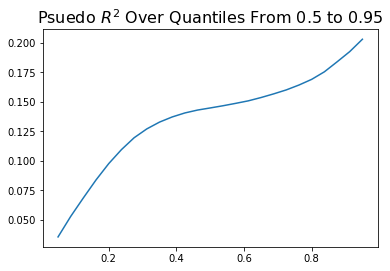

In [30]:
plt.plot(X, Y)
plt.title("Psuedo $R^2$ Over Quantiles From $0.5$ to $0.95$", fontweight='normal', fontsize=16)

In [31]:
# Okay, this data seems *extremely* skewed
# Let's trying logging

import numpy as np

numeric_df['pm25'] = np.log(1 + numeric_df['pm25'])

quant_mod = smf.quantreg(quant_formula, data=numeric_df)
quant_reg = quant_mod.fit(q=.25)

quant_reg.summary()  # "summary" is another very R-thing

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.2292
Model:                       QuantReg   Bandwidth:                      0.1012
Method:                 Least Squares   Sparsity:                        2.806
Date:                Fri, 01 Mar 2019   No. Observations:                41757
Time:                        09:16:09   Df Residuals:                    41751
                                        Df Model:                            5
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2445      0.013    318.119      0.000       4.218       4.271
DEWP           0.0722      0.001     96.791      0.000       0.071       0.074
TEMP          -0.0701      0.001    -83.638      0.000      -0.072      -0.069
Ir            -0.1079      0.004    -29.400      0.000      -0.115      -0.101
hour           0.0215      0.001     23.200      0.000       0.020       0.023
Iws           -0.0040      0.000    -36.695      0.000      -0.004      -0.004
==============================================================================
"""

In [32]:
quant_reg.params

Intercept    4.244503
DEWP         0.072185
TEMP        -0.070149
Ir          -0.107901
hour         0.021524
Iws         -0.004038
dtype: float64

In [33]:
def quant_reg_error(quantile):
    return quant_mod.fit(q=quantile).prsquared

In [34]:
X = np.linspace(5, 95, 25)/100
Y = np.vectorize(quant_reg_error)(X)

Text(0.5,1,'Log Regresssion - Psuedo $R^2$ Over Quantiles From $0.5$ to $0.95$')

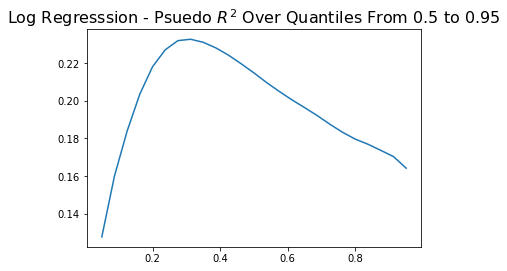

In [35]:
plt.plot(X, Y)
plt.title("Log Regresssion - Psuedo $R^2$ Over Quantiles From $0.5$ to $0.95$", fontweight='normal', fontsize=16)

Overall - in this case, quantile regression is not *necessarily* superior to linear regression. But it does give us extra flexibility and another thing to tune - what the center of what we're actually fitting in the dependent variable.

The basic case of `q=0.5` (the median) minimizes the absolute value of residuals, while OLS minimizes the squared value. By selecting `q=0.25`, we're targeting a lower quantile and are effectively saying that we only want to over-estimate at most 25% of the time - we're being *risk averse*.

Depending on the data you're looking at, and the cost of making a false positive versus a false negative, this sort of flexibility can be extremely useful.

Live - let's consider another dataset! Specifically, "SkillCraft" (data on competitive StarCraft players): http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset

In [ ]:
# TODO Live!
# Hint - we may only care about the *top* quantiles here
# Another hint - there are missing values, but Pandas won't see them right away

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [26]:
from statsmodels.stats import outliers_influence
from sklearn import linear_model, preprocessing, metrics, model_selection
import statsmodels.formula.api as smf
from scipy import special
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#### Load Data

In [2]:
birthweights = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')

In [3]:
birthweights.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


#### Cleaning Data

In [4]:
birthweights.isna().sum()

bwt          0
gestation    0
parity       0
age          0
height       0
weight       0
smoke        0
dtype: int64

#### Data Overview

In [5]:
birthweights.shape

(1174, 7)

In [6]:
birthweights.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


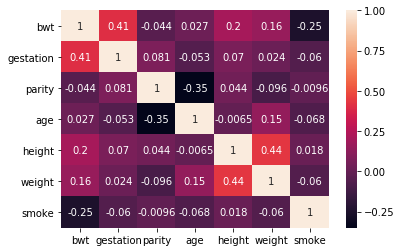

In [7]:
sns.heatmap(birthweights.corr(), annot=True)

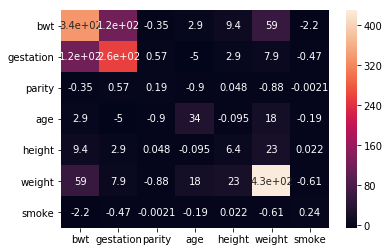

In [8]:
sns.heatmap(birthweights.cov(), annot=True)

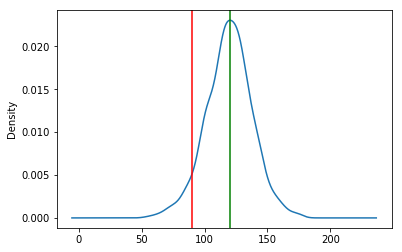

In [9]:
birthweights.bwt.plot.density()
plt.axvline(90, c='r')
plt.axvline(birthweights.bwt.median(), c='g')

In [33]:
# https://en.wikipedia.org/wiki/Standard_normal_table#Cumulative
def std_to_percentile(x):
    return 0.5*(1 + special.erf(x/np.sqrt(2)))

In [34]:
at_risk_std = (90 - birthweights.bwt.mean())/birthweights.bwt.std()

In [70]:
(birthweights.bwt < 90).sum()/birthweights.bwt.size, std_to_percentile((birthweights.bwt < 90).sum()/birthweights.bwt.size), std_to_percentile(at_risk_std), birthweights.bwt.quantile(0.055), np.percentile(birthweights.bwt, 5.5)

(0.054514480408858604, 0.52173736397644954, 0.053977256335247747, 90.0, 90.0)

In [36]:
birthweights.bwt.quantile(std_to_percentile(at_risk_std))

89.31532168124562

In [50]:
print("% of at risk babies:", "{}%".format(birthweights[birthweights.bwt <= 90].size/birthweights.bwt.size * 100))

% of at risk babies: 40.54514480408859%


In [123]:
birthweights[birthweights.bwt == 90].size/birthweights.bwt.size

0.02385008517887564

#### Split Out Data

In [42]:
X = birthweights.drop(columns='bwt')
y = birthweights['bwt']

In [43]:
X.shape, y.size

((1174, 6), 1174)

In [44]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

#### Naive Linear Regression (Baseline)

In [45]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [46]:
metrics.mean_squared_error(model.predict(X_train), y_train), metrics.mean_squared_error(model.predict(X_test), y_test)

(246.26646924356308, 258.04136878262136)

In [47]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.24621044744121157, 0.28613228054912665)

#### Quantile Regression

In [113]:
quantile_model = smf.quantreg('bwt ~ ' + ' + '.join(birthweights.drop(columns='bwt').columns.values), data=X_train.assign(bwt=y_train))
quantile_regression = quantile_model.fit(q=std_to_percentile(at_risk_std))

In [114]:
quantile_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1809
Model:                       QuantReg   Bandwidth:                       6.787
Method:                 Least Squares   Sparsity:                        131.6
Date:                Fri, 01 Mar 2019   No. Observations:                  880
Time:                        15:37:07   Df Residuals:                      873
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -96.2948     38.149     -2.524      0.012    -171.169     -21.421
gestation      0.4618      0.109      4.237      0.000       0.248       0.676
parity        -1.3987      2.678     -0.522      0.602      -6.655       3.858
age           -0.1740      0.194     -0.895      0.371      -0.556       0.208
height         1.3118      0.501      2.621      0.009       0.329       2.294
weight        -0.1104      0.065     -1.703      0.089      -0.238       0.017
smoke         -7.3684      2.080     -3.543      0.000     -11.451      -3.286
==============================================================================

The condition number is large, 9.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [115]:
metrics.mean_squared_error(quantile_regression.predict(X_train), y_train), metrics.mean_squared_error(quantile_regression.predict(X_test), y_test)

(895.18870866602151, 872.04125171317605)

In [116]:
metrics.r2_score(y_train, quantile_regression.predict(X_train)), metrics.r2_score(y_test, quantile_regression.predict(X_test))

(-1.7400559168031258, -1.4124895266386286)

In [117]:
quantile_regression.params

Intercept   -96.294841
gestation     0.461792
parity       -1.398690
age          -0.174046
height        1.311831
weight       -0.110387
smoke        -7.368382
dtype: float64

In [118]:
pd.Series([outliers_influence.variance_inflation_factor(birthweights.values, x) for x in range(birthweights.columns.size)], index=birthweights.columns)

bwt           57.108426
gestation    267.200997
parity         1.577752
age           25.692524
height       311.948478
weight        48.959558
smoke          1.777358
dtype: float64

In [121]:
for q in [.1, .25, .5, .75, .9]:
    quantile_model = smf.quantreg('bwt ~ ' + ' + '.join(birthweights.drop(columns='bwt').columns.values), data=X_train.assign(bwt=y_train))
    quantile_regression = quantile_model.fit(q=q)
    r2 = quantile_regression.prsquared
    print("{}: {}".format(q, r2))

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


0.1: 0.16970575307885938
0.25: 0.1567246163236482
0.5: 0.1320269718413859
0.75: 0.11921219960994789
0.9: 0.10600962381613355


#### Response

- It seems that the most predictive features are of the weight of a baby at birth, is whether the 
  mother has smoked and the gestation period prior to birth. While the `parity` feature
  has the second highest magnitude among the featues, it's p-value indicates that it's 
  not significant.
- It should be recommended that mothers not smoke

## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model